# Appendix B: impute values for censored median_house_values

## Overview

Appendix B applies the imputation method set out in Appendix A to the records with censored median house values.

We see in what follows that here we only need to use Approach 1 to improve upon the original Gibbs output in terms of both its mean and its distribution.  With the Approach 1 adjustment, we come very close to approximating the hypothesized distribution.



                                  * * * * *
                                               

# Section 1: get a prediction for the mean of the actual, unobserved values

In [ ]:
# Load some of the packages we will use.

require(repr)    # allows us to resize the plots
require(stringr)
require(ggplot2)
require(car)     # needed for diagnostic tools
require(arm) 


In [2]:
options(digits = 5, show.signif.stars = F, 
        mc.cores=parallel::detectCores())


In [3]:
# This dataset contains imputed values for housing_median_age.  
# The imputation was done in Appendix A.

dat <- read.csv("/home/greg/Documents/stat/Geron_ML/datasets/housing/housing_cleaned_v03b.csv",
                header=TRUE, row.names=1,
                colClasses= c("character", rep("numeric", 9), "character",
                              rep("numeric", 5)))
dim(dat)


[1] 20603    15

In [4]:
# Check that we have imputed values for housing_median_age.
# Prior to the imputation done in Appendix A, the age values
# were capped at 52.

summary(dat$housing_median_age)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0    18.0    29.0    29.0    37.0    71.6 

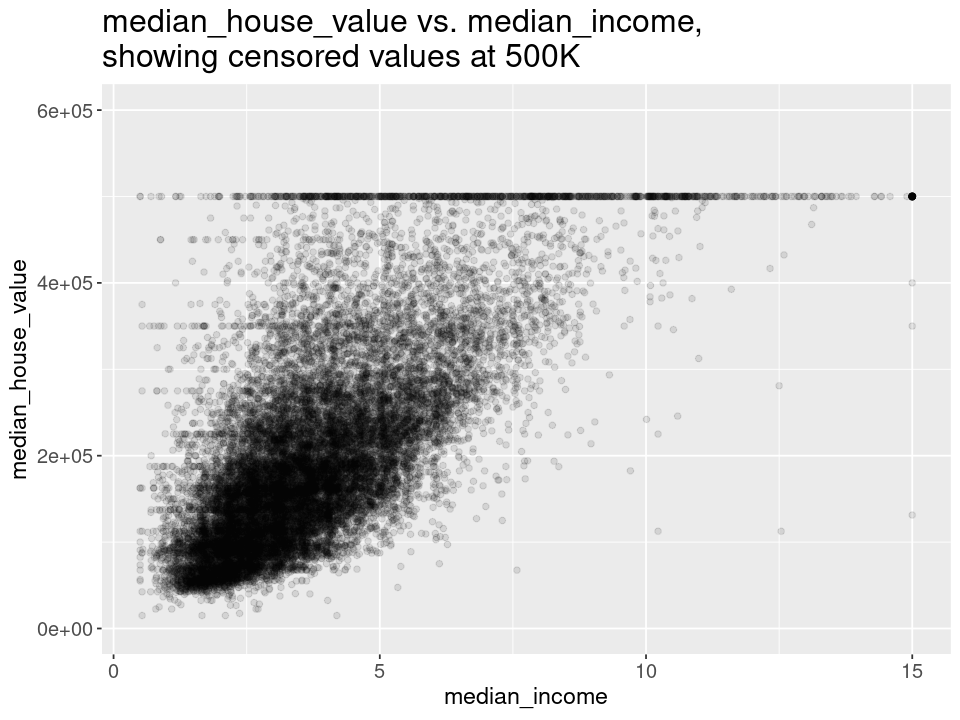

In [5]:
# Plot of median_house_value vs. median_income. 
# 4.8% of the data is censored at 500K.  Of all
# of the predictors, median_house_value is most 
# highly correlated with median_income.

options(repr.plot.width= 8, repr.plot.height= 6)

p <- ggplot(dat, aes(median_income, median_house_value)) +
  geom_point(alpha= 0.1) + xlab("median_income") + ylab("median_house_value") +
  ylim(0, 600000) +
  ggtitle("median_house_value vs. median_income, 
showing censored values at 500K") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
  
p


In [6]:
# There are 990 records, or districts, with a 
# censored median_house_value.

nrow(dat[which(dat$median_house_value >= 500000),])


[1] 990

## Get record counts for 15K interval bins of median_house_value

In order to mimic the age-level counts from Appendix A, we need to discretize median_house_value.  For presentation purposes, I have chosen 15K rather than 10K for the interval size in order to reduce the variability in the counts.

For modeling purposes I make use of 10K bins because I want a prediction at 500K and 500K is not divisible by 15K.  This lack of even division could potentially have a negative effect on the prediction at 500K.

In [7]:
summary(dat$median_house_val)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  14999  119600  179800  206908  264950  500001 

In [8]:
# Let 15K be the lowest median_house_value in our dataset.

dat[which(dat$median_house_value < 15000), c("median_house_value")] <- 15000


In [9]:
# Function for obtaining the number of records in each 15K 
# interval.

get_rcd_counts <- function(med_houseVal, varRange, 
                           span=15000, startpt=15000) {  
    
    cell_floors <- seq(from=startpt, to=990000, by=span)
    names(cell_floors) <- paste(as.character(cell_floors/1000), "K", sep="")
    
    cell_floors_tmp <- cell_floors[(as.numeric(cell_floors) >= varRange[1]) &
                                   (as.numeric(cell_floors) <= varRange[2])]
    
    # This function returns record counts up to, but not including,
    # varRange[2].
    n <- length(cell_floors_tmp) - 1
    counts <- rep(NA, n)
    for(i in 1:n) {
        lower <- as.numeric(cell_floors_tmp[i])
        upper <- as.numeric(cell_floors_tmp[i + 1])
        counts[i] <- length(med_houseVal[((med_houseVal >= lower) &
                                          (med_houseVal < upper))])
    }
    names(counts) <- names(cell_floors_tmp)[1:n]
    return(counts) 
}


In [10]:
cell_floors <- seq(from= 15000, to= 495000, by= 15000)
length(cell_floors)
names(cell_floors) <- paste(as.character(cell_floors/1000), "K", sep="")
print(cell_floors)


[1] 33

   15K    30K    45K    60K    75K    90K   105K   120K   135K   150K   165K 
 15000  30000  45000  60000  75000  90000 105000 120000 135000 150000 165000 
  180K   195K   210K   225K   240K   255K   270K   285K   300K   315K   330K 
180000 195000 210000 225000 240000 255000 270000 285000 300000 315000 330000 
  345K   360K   375K   390K   405K   420K   435K   450K   465K   480K   495K 
345000 360000 375000 390000 405000 420000 435000 450000 465000 480000 495000 


In [11]:
observed_counts <- get_rcd_counts(dat$median_house_value, c(15000, 495000))

print(observed_counts)


 15K  30K  45K  60K  75K  90K 105K 120K 135K 150K 165K 180K 195K 210K 225K 240K 
  14   78  587  965 1025 1295 1205 1088 1284 1538 1234 1239  842  931  959  747 
255K 270K 285K 300K 315K 330K 345K 360K 375K 390K 405K 420K 435K 450K 465K 480K 
 656  615  439  355  353  400  386  266  207  190  163  135  115  134   81   68 


In [12]:
# Get the number of records not captured in observed_counts.

nrow(dat) - (sum(observed_counts) + 990)


[1] 19

In [13]:
# The 19 records are between 495K and 500K.

nrow(dat[which((dat$median_house_value >= 495000) & 
               (dat$median_house_value < 500000)),])

excluded_rows <- rownames(dat[which((dat$median_house_value >= 495000) & 
                                    (dat$median_house_value < 500000)),])


[1] 19

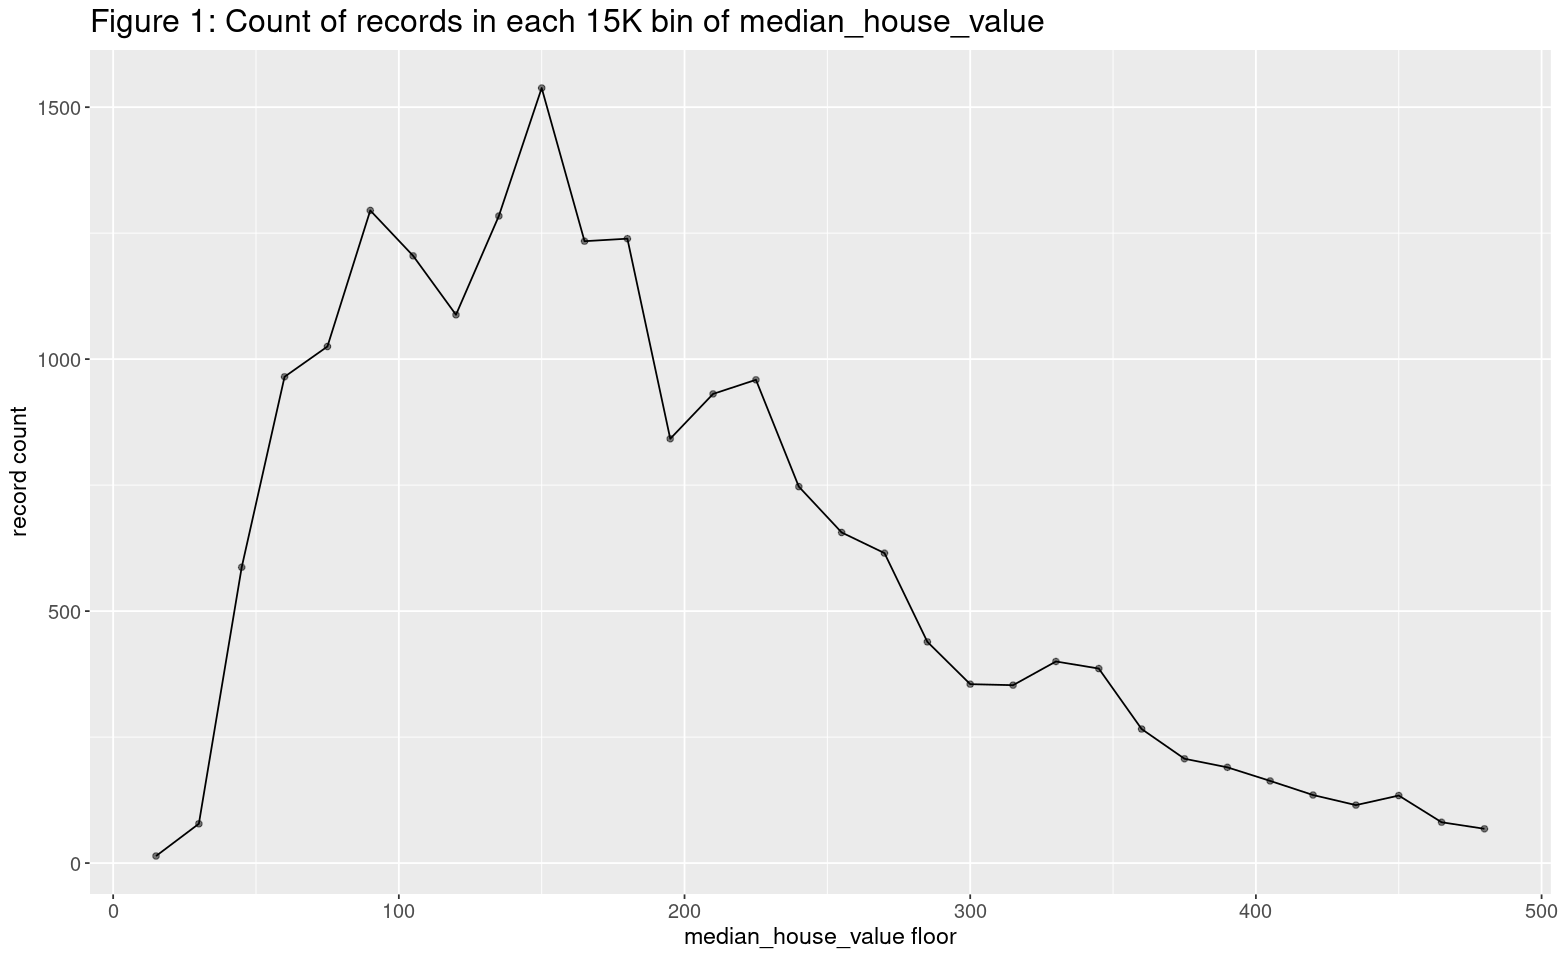

In [14]:
# Plot the counts.  This will give us a very general idea
# of what the distribution of counts might look like for the
# 990 records which need an imputed value.  We are especially
# interested in the general shape of the distribution from
# around 350K onwards.

df_plot <- rep(NA, 2 * length(observed_counts))
dim(df_plot) <- c(length(observed_counts), 2)
df_plot <- as.data.frame(df_plot)
colnames(df_plot) <- c("cell", "count")

new_names <- str_replace_all(names(observed_counts), "[K]", "")
df_plot$cell <- as.numeric(new_names)
df_plot$count <- as.numeric(observed_counts)


options(repr.plot.width= 13, repr.plot.height= 8)

p <- ggplot(df_plot, aes(cell, count)) +
  geom_point(alpha= 0.5) + xlab("median_house_value floor") + 
  ylab("record count") +
  geom_line() +
  ggtitle("Figure 1: Count of records in each 15K bin of median_house_value") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


In [15]:
# There is much less variability in the tail of the distribution.

dim(df_plot)
print(sd(df_plot$count))
print(sd(df_plot[24:32,]$count))


[1] 32  2

[1] 460.4
[1] 62.905


## Hypothesized distribution

We have a general idea of what the distribution of the actual, unobserved values will look like.  Here I construct an example, or hypothesized, distribution.  We know that as median house values increase, the number of districts (i.e., census blocks) will decrease; the correlation between these two variables is over 90\%.  Among the 990 records for which we need to impute a value, there are probably a few outliers, but we do not need to worry about trying to predict for these.  Instead, we are interested in approximating what is likely to be the distribution for the vast majority of records.

The hypothesized distribution provides us with a way to judge the plausibility of our model-based prediction for the mean.



In [16]:
# Create an example, or hypothesized, distribution for the 
# expected range of imputation.  A good initial estimate
# for the upper limit of the range is to multiply the cap
# by 1.6.  1.6 * 500 = 800.

bins <- seq(495000, 810000, by= 15000)
bin_names <- paste(as.character(bins/1000), "K", sep="")
names(bins) <- bin_names
names(bins)
length(bins)
# 22

# In addition to the 990 records to distribute, we have 19
# records that belong to the 495K cell.
bin_counts <- c(89, 95, 89, 86, 78, 71, 67, 65, 56, 51, 48, 
                42, 38, 35, 27, 22, 17, 12, 8,  6,  4,  3)
sum(bin_counts)
sum(bin_counts) == (990 + 19)


[1] "495K" "510K" "525K" "540K" "555K" "570K" "585K" "600K" "615K" "630K"
[11] "645K" "660K" "675K" "690K" "705K" "720K" "735K" "750K" "765K" "780K"
[21] "795K" "810K"

[1] 22

[1] 1009

[1] TRUE

In [17]:
# Construct a dataframe for plotting of the example distribution.

all_names <- c(df_plot$cell[24:31], bin_names)
observed <- df_plot$count[24:31]

all <- c(observed, bin_counts)
n <- length(all)

dftmp <- rep(NA, 2 * n)
dim(dftmp) <- c(n, 2)
dftmp <- as.data.frame(dftmp)
colnames(dftmp) <- c("cell", "count")
dftmp$cell <- all_names
dftmp$count <- all

dftmp$hhval <- as.numeric(str_replace_all(dftmp$cell, "[K]", ""))

head(dftmp); tail(dftmp)


,cell,count,hhval
,<chr>,<dbl>,<dbl>
1,360,266,360
2,375,207,375
3,390,190,390
4,405,163,405
5,420,135,420
6,435,115,435


,cell,count,hhval
,<chr>,<dbl>,<dbl>
25,735K,17,735
26,750K,12,750
27,765K,8,765
28,780K,6,780
29,795K,4,795
30,810K,3,810


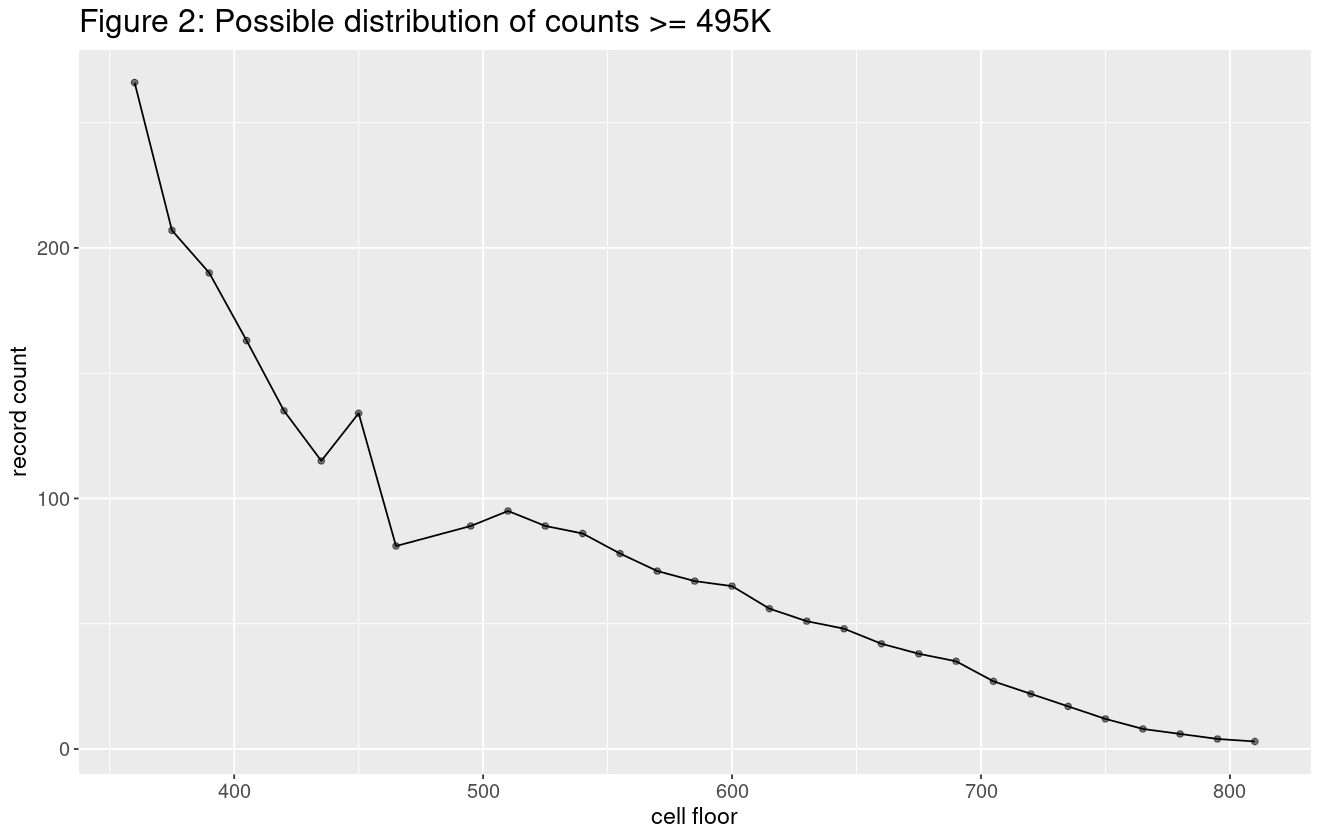

In [18]:
# Plot showing possible distribution of 990 + 19 districts 
# with a median_house_value >= 495K.

options(repr.plot.width= 11, repr.plot.height= 7)

p <- ggplot(dftmp, aes(hhval, count)) +
  geom_point(alpha= 0.5) + xlab("cell floor") + ylab("record count") +
  geom_line() +
  ggtitle("Figure 2: Possible distribution of counts >= 495K") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


### Construct 10K bins

The virtue of the larger 15K bins is that it is easier to assign counts when trying to make concrete a hypothesized distribution.  But 10K bins will give us a better first prediction for the mean, and the smaller bins should also help with the model-based prediction. 


In [19]:
# Create a vector of values based on the 15K bin assignments
# which can then be used to create 10K bin counts.

dftmp <- dftmp[which(dftmp$hhval >= 495),]

# newvals will be used in cells downstream.
newvals <- c()
for(i in 1:nrow(dftmp)) {
    
    # Remove the 19 rcds >= 495K and < 500K.
    ifelse(i > 1, n <- dftmp$count[i], n <- dftmp$count[i] - 19)
    
    ifelse(i > 1, lower <- dftmp$hhval[i], lower <- dftmp$hhval[i] + 5)
    ifelse(i > 1, upper <- lower + 15, upper <- lower + 10)
    
    seed <- set.seed(4321 + i)
    vals <- round(runif(n, lower, upper))
    newvals <- c(newvals, vals)
}

length(newvals)
# 990


[1] 990

In [20]:
imputed_vals_tmp <- 1000* newvals


In [21]:
# Combine the newly imputed values with the median house
# values in dat that are not censored.

all_hh_median_vals <- c(dat[which(dat$median_house_value < 500000), c("median_house_value")],
                        imputed_vals_tmp)
length(all_hh_median_vals)
summary(all_hh_median_vals)


[1] 20603

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  15000  119600  179800  211694  264950  824000 

In [23]:
# Get record counts in each 10K bin from 50K up to 840K.

all_counts <- get_rcd_counts(all_hh_median_vals, c(60000, 830000), span=10000, startpt=60000)

print(all_counts)


 60K  70K  80K  90K 100K 110K 120K 130K 140K 150K 160K 170K 180K 190K 200K 210K 
 625  598  767  919  734  847  723  847  802  968  999  805  852  694  535  637 
220K 230K 240K 250K 260K 270K 280K 290K 300K 310K 320K 330K 340K 350K 360K 370K 
 676  577  494  448  461  454  336  264  232  234  242  264  242  280  200  145 
380K 390K 400K 410K 420K 430K 440K 450K 460K 470K 480K 490K 500K 510K 520K 530K 
 128  127  113  113   82   99   69  109   50   56   47   40   66   64   63   58 
540K 550K 560K 570K 580K 590K 600K 610K 620K 630K 640K 650K 660K 670K 680K 690K 
  54   65   45   47   46   46   47   41   33   33   38   29   31   22   27   25 
700K 710K 720K 730K 740K 750K 760K 770K 780K 790K 800K 810K 820K 
  18   18   16   11   14    9    6    5    3    3    4    2    1 


In [26]:
length(all_counts)

# Find the index at 500K:
which(names(all_counts)== "500K")


[1] 77

[1] 45

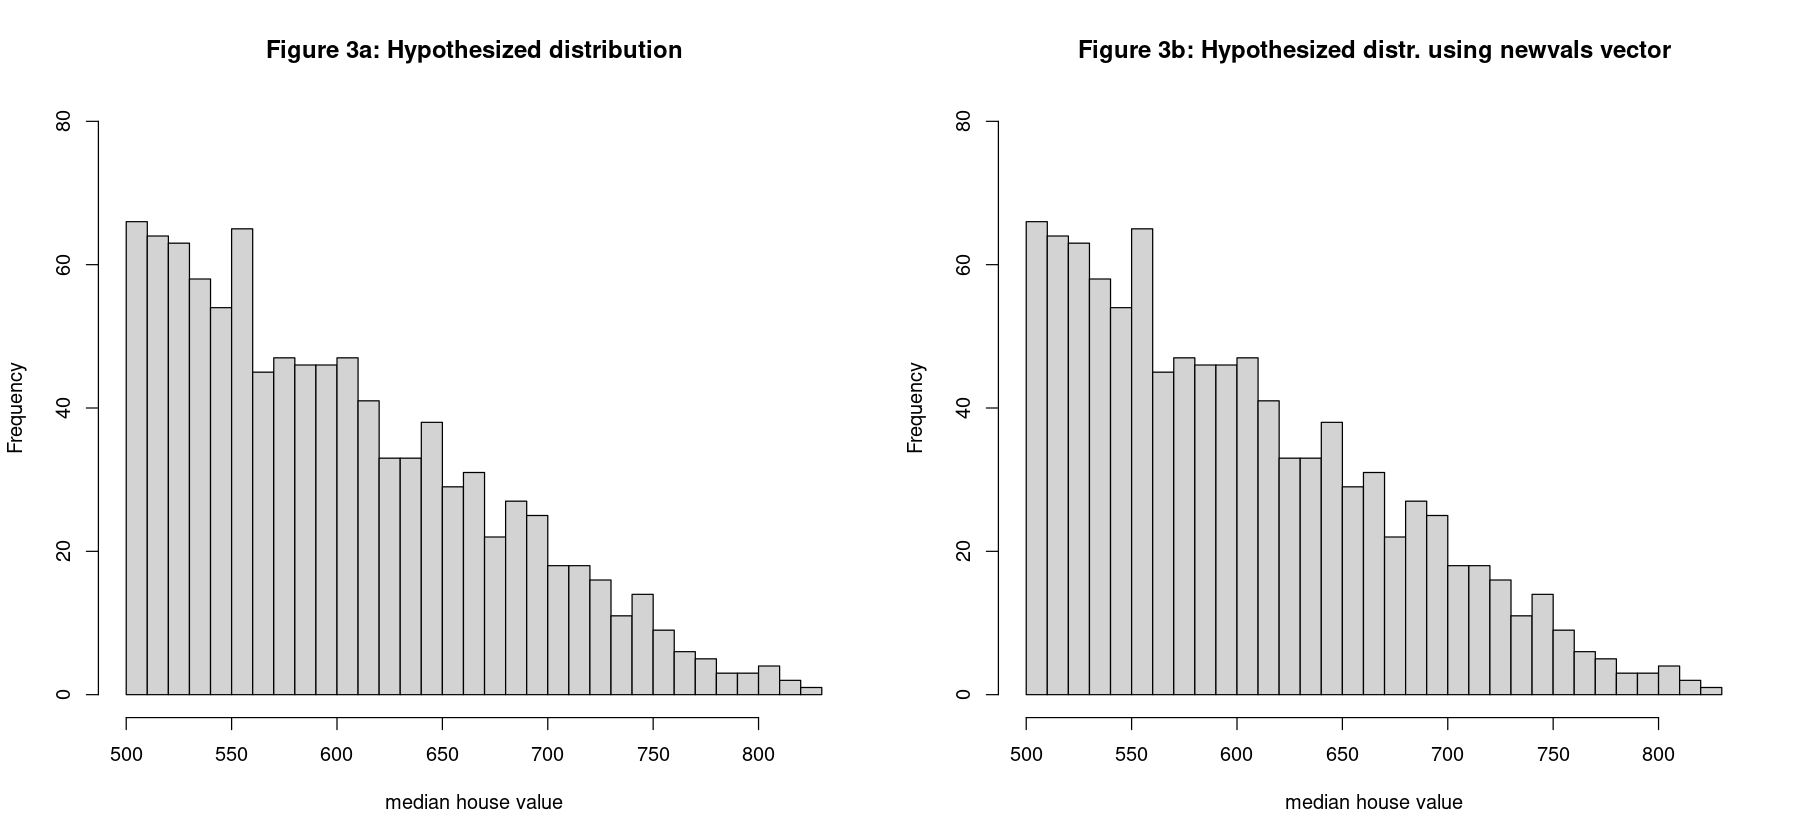

In [28]:
# The histogram below shows the counts for the example
# distribution; this is a close-up of Figure 2.

tbl <- all_counts[45:77]

options(repr.plot.width= 15, repr.plot.height= 7)

mat <- t(as.matrix(c(1,2)))
layout(mat, widths = rep.int(20, ncol(mat)),
       heights = rep.int(7, nrow(mat)), respect = FALSE)

hist(rep(seq(500, 820, by=10), as.numeric(tbl)) + 1, breaks=30, xlab="median house value",
     main="Figure 3a: Hypothesized distribution", ylim=c(0, 80))

hist(newvals + 1, breaks= 30, xlab="median house value", ylim=c(0, 80),
     main="Figure 3b: Hypothesized distr. using newvals vector")


In [29]:
# Smooth out the counts in our 10K bins.

print(tbl[1:33])


500K 510K 520K 530K 540K 550K 560K 570K 580K 590K 600K 610K 620K 630K 640K 650K 
  66   64   63   58   54   65   45   47   46   46   47   41   33   33   38   29 
660K 670K 680K 690K 700K 710K 720K 730K 740K 750K 760K 770K 780K 790K 800K 810K 
  31   22   27   25   18   18   16   11   14    9    6    5    3    3    4    2 
820K 
   1 


In [35]:
tbl02 <- tbl

tbl02["500K"] <- 66; tbl02["510K"] <- 64
tbl02["530K"] <- 61; tbl02["540K"] <- 58
tbl02["550K"] <- 55; tbl02["560K"] <- 51

tbl02["570K"] <- 48; tbl02["590K"] <- 44
tbl02["600K"] <- 41; tbl02["620K"] <- 38
tbl02["630K"] <- 35; tbl02["640K"] <- 32
tbl02["660K"] <- 29; tbl02["670K"] <- 25
tbl02["730K"] <- 13

sum(tbl02)


[1] 990

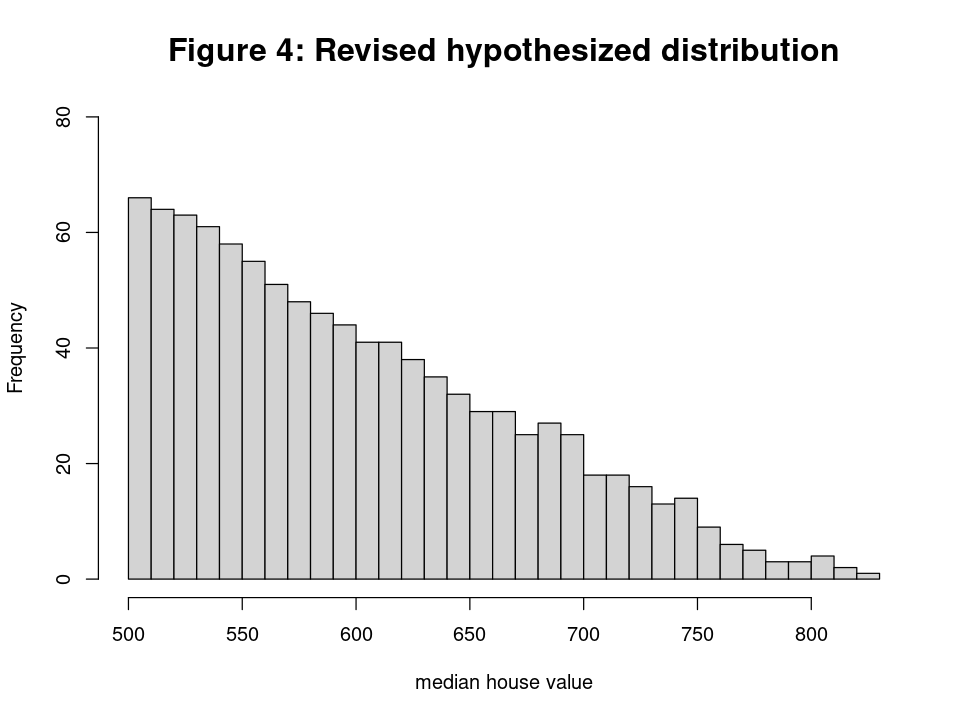

In [36]:
# Check the shape of the revised hypothesized distribution.

options(repr.plot.width= 8, repr.plot.height= 6)

hist(rep(seq(500, 820, by=10), as.numeric(tbl02)) + 1, breaks=30, xlab="median house value",
     main="Figure 4: Revised hypothesized distribution", 
     cex.main= 1.6, ylim=c(0, 80))


In [37]:
# Compute the mean and median of our hypothesized distribution.

# newvals will be used in cells downstream.
newvals <- c()
for(i in 1:length(tbl)) {
    
    n <- as.numeric(tbl[i])
    bin_name <- names(tbl[i])
    bin_name <- str_replace(bin_name, "K", "")
    lower <- as.numeric(bin_name)
    upper <- lower + 10
    
    seed <- set.seed(4321 + i)
    vals <- round(runif(n, lower, upper))
    newvals <- c(newvals, vals)
}

length(newvals)
# 990
round(mean(newvals), 1)
# 600
round(median(newvals), 1)
# 587


[1] 990

[1] 600

[1] 587

In [38]:
imputed_vals_tmp <- 1000 * newvals


In [ ]:
### COMMENTS:

# FIRST PREDICTION FOR THE MEAN: 600K

# PREDICTION FOR THE MEDIAN: 587K


## Compute shift-increment ratios for the mean with 240K window

As discussed in Appendix A, the size of the window matters for these ratios.  This was not the case so much for the housing_median_age data of Appendix A.  But for median_house_value, the window size matters quite a bit.  If I use a window of 250K, the ratios are too large.  We know this because a 95% prediction interval will not cover our first prediction for the mean.

Compute data for our prediction model from 60K - 330K.  Although this takes us into the region of imputed values (see Figure 4), most of the data for the last few 240K windows will still be observed rather than imputed.  See Appendix A for an example; by doing this, I should be able to obtain a far more accurate prediction for the mean. 

In Appendix A we saw that predicting the median is not so easy.  Here I do not worry about getting a prediction for the median.  As in Appendix A, we know that the median will lie somewhere to the left of the mean, and our hypothesized distribution gives us some idea of the expected distance between the mean and the median.



In [39]:
bins <- seq(60000, 330000, by= 10000)
bin_names <- paste(as.character(bins/1000), "K", sep="")
names(bins) <- bin_names
length(bins)


[1] 28

In [40]:
# See Figure 3b.
summary(newvals)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    500     539     587     600     649     822 

In [41]:
# Combine the newly imputed values with the median house
# values in dat that are not censored.

all_hh_median_vals <- c(dat[which(dat$median_house_value < 500000), c("median_house_value")],
                        newvals*1000)
length(all_hh_median_vals)
summary(all_hh_median_vals)


[1] 20603

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  15000  119600  179800  211715  264950  822000 

In [42]:
# Get the means for each bin, using a 240K window.   

mean_ratios <- rep(NA, length(bins))
means <- rep(NA, length(bins))
rcd_count <- rep(NA, length(bins))

span <- 240000
index <- 0
for(floor in bins) {
    
    index <- index + 1
    hhvals <- as.numeric(all_hh_median_vals[which((all_hh_median_vals >= floor) &
                                                  (all_hh_median_vals < (floor + span)))])
    counts <- as.numeric(get_rcd_counts(hhvals, c(floor, (floor+span)), 
                                        span=10000, startpt=60000))
    rcd_count[index] <- sum(counts)
    
    # Compute mean.
    hhval_mean <- round(mean(hhvals), 5)
    mean_ratios[index] <- round(hhval_mean/floor, 4)
    means[index] <- hhval_mean

}

paste0("These are the 240K shift increments for the means: ")
names(mean_ratios) <- bin_names
print(mean_ratios)


[1] "These are the 240K shift increments for the means: "

   60K    70K    80K    90K   100K   110K   120K   130K   140K   150K   160K 
2.7703 2.4613 2.2286 2.0613 1.9420 1.8335 1.7548 1.6767 1.6129 1.5564 1.5175 
  170K   180K   190K   200K   210K   220K   230K   240K   250K   260K   270K 
1.4883 1.4572 1.4327 1.4085 1.3775 1.3612 1.3462 1.3318 1.3160 1.3005 1.2932 
  280K   290K   300K   310K   320K   330K 
1.2909 1.2841 1.2734 1.2614 1.2533 1.2464 


In [43]:
# Construct dataframe for plotting, etc.

df_ratios <- rep(NA, 4*length(mean_ratios))
dim(df_ratios) <- c(length(mean_ratios), 4)
df_ratios <- as.data.frame(df_ratios)
colnames(df_ratios) <- c("cell", "rcds","mean","mean_ratio")
df_ratios$cell <- bins
df_ratios$rcds <- rcd_count
df_ratios$mean_ratio <- mean_ratios
df_ratios$mean <- means


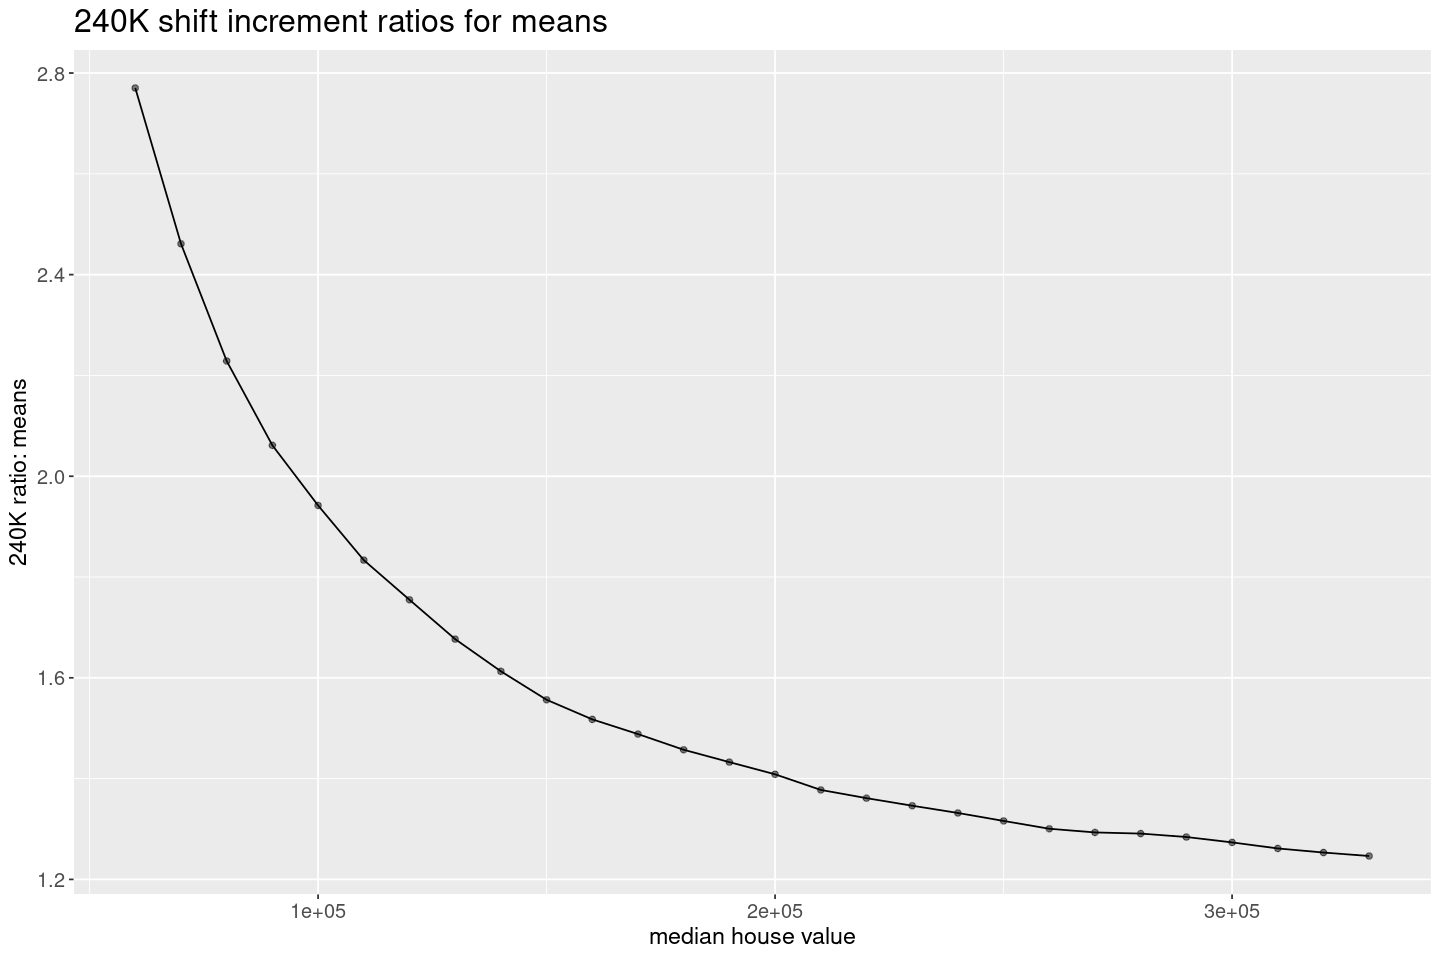

In [44]:
options(repr.plot.width= 12, repr.plot.height= 8)

p <- ggplot(df_ratios, aes(cell, mean_ratio)) +
  geom_point(alpha= 0.5) + xlab("median house value") + 
  ylab("240K ratio: means") +
  geom_line() +
  ggtitle("240K shift increment ratios for means") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


In [45]:
# rcds is highly correlated with cell (correlation > 0.90).
# This means that using both cell and rcds as predictors in a
# model might not be a good idea.
# We might need to use WLS to control the variance in our model.

df_ratios$rcds


[1] 16062 15669 15305 14780 14125 13633 13066 12543 11841 11167 10326  9440
[13]  8748  7978  7383  6917  6389  5763  5242  4795  4387  3988  3597  3327
[25]  3121  2941  2768  2575

In [46]:
g01 <- lm(I(mean_ratio^0.27) ~  I(cell^0.04) 
          + I((cell^0.04)^2) + I((cell^0.04)^3), 
          data= df_ratios)

ans <- summary(g01)
ans[[1]] <- ""; ans



Call:
""

Residuals:
      Min        1Q    Median        3Q       Max 
-1.91e-03 -6.47e-04  4.73e-05  6.44e-04  1.73e-03 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)
(Intercept)        230.28      28.97    7.95  3.5e-08
I(cell^0.04)      -394.45      54.00   -7.31  1.5e-07
I((cell^0.04)^2)   226.10      33.54    6.74  5.7e-07
I((cell^0.04)^3)   -43.17       6.94   -6.22  2.0e-06

Residual standard error: 0.000992 on 24 degrees of freedom
Multiple R-squared:     1,	Adjusted R-squared:     1 
F-statistic: 4.33e+04 on 3 and 24 DF,  p-value: <2e-16


In [47]:
ncvTest(g01)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.036798, Df = 1, p = 0.848

In [48]:
residualPlots(g01, plot=FALSE)


                 Test stat Pr(>|Test stat|)
I(cell^0.04)         -1.28             0.21
I((cell^0.04)^2)     -0.20             0.85
I((cell^0.04)^3)     -0.21             0.84
Tukey test           -0.07             0.95


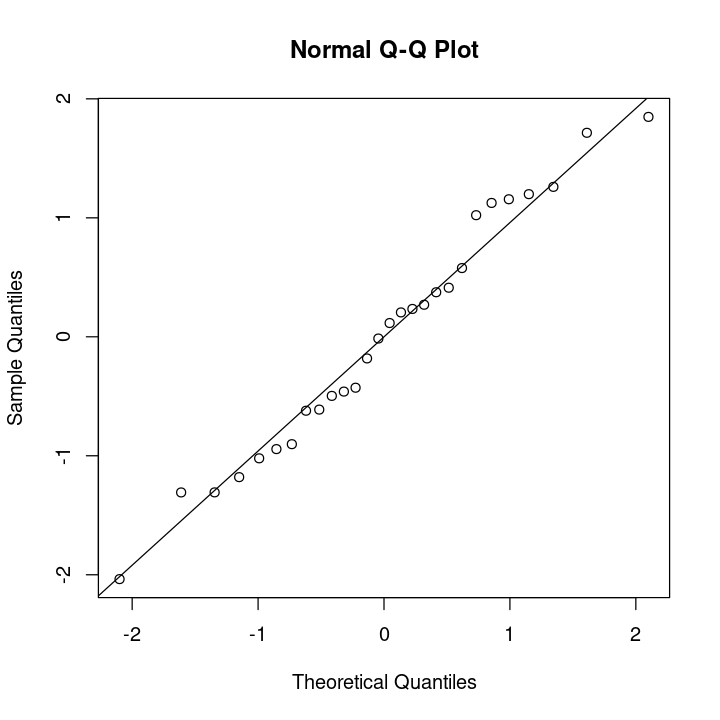

In [49]:
options(repr.plot.width= 6, repr.plot.height= 6)

ans <- qqnorm(scale(residuals(g01, type= "pearson")))
qqline(ans$x, probs = c(0.25, 0.75))


In [50]:
# Prediction for mean for [500K, 800K].

newdat <- df_ratios[1, ]
newdat[1, ] <- c(500000, rep(NA, 3))

ans <- predict.lm(g01, newdata= newdat, type= "response")
ans_transf <- ans^(1/0.27); ans_transf
# 1.2079

# 1.2079 * 500K = 604K.


1 
1.2079

In [51]:
# Compute a 95% prediction interval.

pred_ans <- predict.lm(g01, newdata= newdat, interval="prediction",
                       level=0.95)
pred_ans_transf <- pred_ans^(1/0.27); pred_ans_transf


,fit,lwr,upr
1,1.2079,1.1823,1.2339


In [52]:
lwr <- round(pred_ans_transf[2] * 500)
upr <- round(pred_ans_transf[3] * 500)

clause <- "95% prediction interval for estimate of the mean of the actual, unobserved values: "
print_ans <- paste0("[", lwr, "K, ", upr ,"K]")
paste0(clause, print_ans)
# [591K, 617K]


[1] "95% prediction interval for estimate of the mean of the actual, unobserved values: [591K, 617K]"

### Compute 95% prediction interval using simulation

In [57]:
# The sim function is from the arm package.

n.sims <- 3000
sim.g01 <- sim(g01, n.sims)
y.tilde <- array(NA, c(n.sims, 1))
X.tilde <- cbind(1, 500000^0.04, 500000^0.08, 500000^0.12)


In [58]:
X.tilde


1,1.6903,2.857,4.8292


In [59]:
dim(y.tilde)


[1] 3000    1

In [60]:
str(sim.g01)


Formal class 'sim' [package "arm"] with 2 slots
  ..@ coef : num [1:3000, 1:4] 220 231 193 250 230 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : NULL
  .. .. ..$ : chr [1:4] "(Intercept)" "I(cell^0.04)" "I((cell^0.04)^2)" "I((cell^0.04)^3)"
  ..@ sigma: num [1:3000] 0.001091 0.000797 0.001056 0.000761 0.000903 ...


In [61]:
beta <- coef(sim.g01)
dim(beta)
colnames(beta)


[1] 3000    4

[1] "(Intercept)"      "I(cell^0.04)"     "I((cell^0.04)^2)" "I((cell^0.04)^3)"

In [62]:
beta[5:8,]


(Intercept),I(cell^0.04),I((cell^0.04)^2),I((cell^0.04)^3)
229.65,-393.59,225.75,-43.135
228.77,-391.54,224.24,-42.772
241.69,-415.69,239.27,-45.893
215.39,-366.54,208.67,-39.542


In [63]:
(sigma <- sigma.hat(sim.g01))[1:4]


[1] 0.00109132 0.00079679 0.00105563 0.00076126

In [64]:
for(s in 1:n.sims) {
    
    y.tilde[s, ] <- (rnorm(1, X.tilde %*% beta[s,], sigma[s]))^(1/0.27)
}


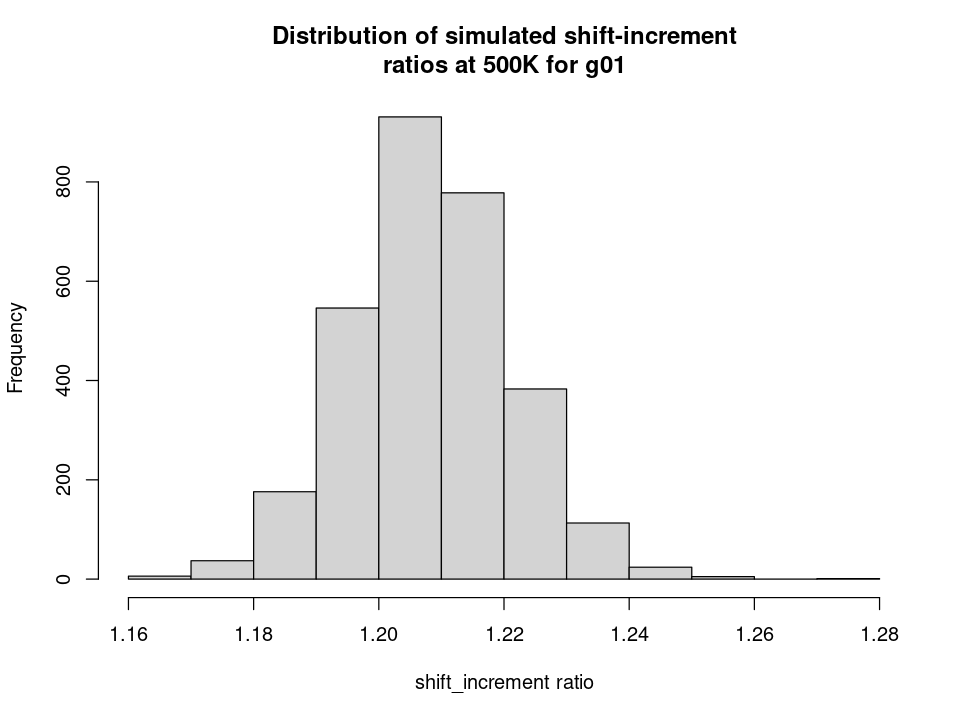

In [65]:
dist <- as.numeric(y.tilde[, 1])

options(repr.plot.width= 8, repr.plot.height= 6)

hist(dist, main="Distribution of simulated shift-increment
ratios at 500K for g01", xlab="shift_increment ratio")


In [66]:
# We get very close to our first set of results.

ans <- quantile(dist*500000, probs=c(0.025, 0.975))
result <- round(as.numeric(ans))
names(result) <- names(ans); print(round(result/1000))


 2.5% 97.5% 
  592   617 


## Final Comments for Section 1

As noted in Appendix A, if we have a good prediction for the mean of the actual, unobserved values (by "good" I mean a prediction which we can have a degree of confidence in), then we can improve upon the Gibbs sampler output if its predictions have a mean where we do not think it actually is.  From the above we can be fairly confident that the mean for the median house values >= 500K is close to **604K**.  We can be fairly confident that the median will be less than the mean.

As noted in Appendix A, it is much harder to predict for the median than it is for the mean.  But we already have one prediction for the median (587K) using the hypothesized distribution.

For a point estimate of the mean I will use the 604K number rather than the 600K number (the first prediction) because the model-based estimate also depends on the data < 500K.  Also, the slightly larger number will lead to a slightly smaller adjustment of the Gibbs output below.



# Section 2: impute values for censored median house values

In [185]:
# The following model is what we will use to predict the
# median house values that we need.

m01 <- lm(I(median_house_value^0.18) ~ 
          
           I(median_income^0.77) +
           I(long_transf^-0.5) +
           I(long_transf^-1) +
           I(long_transf^-1.5) +
           latitude +
           I(latitude^2) +
           I(latitude^3) + 
           I(latitude^4) +
           pop_per_hh +
           I(pop_per_hh^2) +
           I(housing_median_age^0.15) +
           HHdens_ln +
           HHdens_ln:long_transf +
           HHdens_ln:median_income +
           HHdens_ln:housing_median_age:median_income,
                  
          data= dat)

# REMARK: dat includes the capped data; if we discard the censored
# records, we are discarding valuable information.

m01.summary <- summary(m01)
m01.summary[[1]] <- ""; round(m01.summary$adj.r.squared, 3)


[1] 0.73

In [186]:
ncvTest(m01)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.00045257, Df = 1, p = 0.983

In [187]:
residualPlots(m01, plot=FALSE)


                           Test stat Pr(>|Test stat|)
I(median_income^0.77)         -14.13           <2e-16
I(long_transf^-0.5)             1.99            0.046
I(long_transf^-1)              11.11           <2e-16
I(long_transf^-1.5)            11.55           <2e-16
latitude                        0.89            0.373
I(latitude^2)                  -0.40            0.692
I(latitude^3)                  33.30           <2e-16
I(latitude^4)                  33.28           <2e-16
pop_per_hh                     -1.32            0.186
I(pop_per_hh^2)               -13.36           <2e-16
I(housing_median_age^0.15)      0.46            0.643
HHdens_ln                      11.34           <2e-16
Tukey test                      0.07            0.945


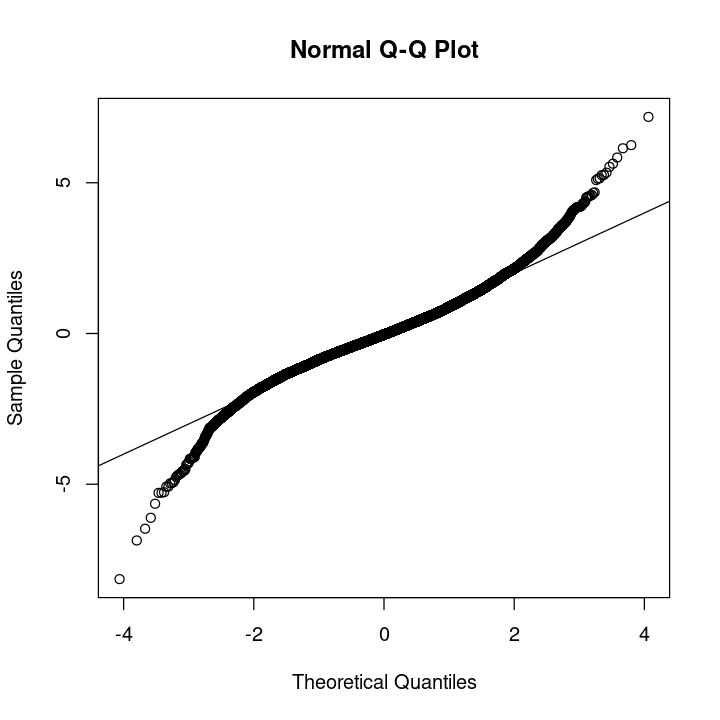

In [188]:
options(repr.plot.width= 6, repr.plot.height= 6)

ans <- qqnorm(scale(residuals(m01, type= "pearson")))
qqline(ans$x, probs = c(0.25, 0.75))


In [189]:
# Get a sense of the uncertainty for the model's sigma.
# (sim is from the arm package.)

m01.sim <- sim(m01, n.sims=3000)


In [190]:
sigma.m01.sim <- sigma.hat(m01.sim)
str(sigma.m01.sim)


 num [1:3000] 0.46 0.469 0.47 0.465 0.465 ...


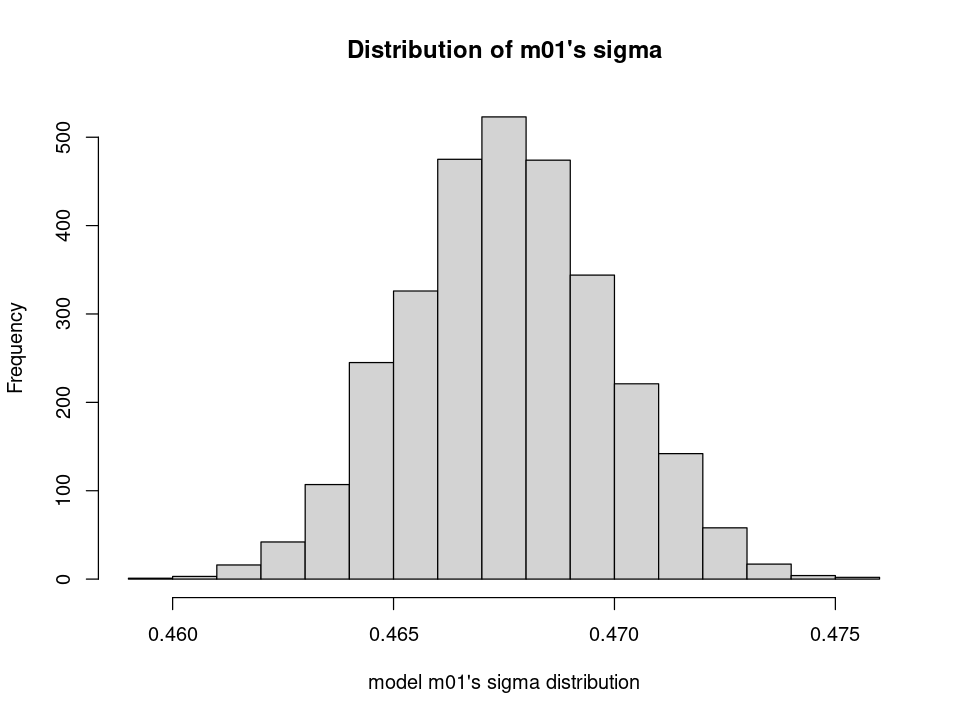

In [191]:
options(repr.plot.width= 8, repr.plot.height= 6)

hist(sigma.m01.sim, breaks=20, main="Distribution of m01's sigma",
     xlab="model m01's sigma distribution")


In [ ]:
# sigma.hat is small because of the power transformation
# on the response variable.


### Gibbs sampler for imputing censored median_house_values

In [67]:
# Because of the transformation on the response variable,
# we need to transform our limits.  Here I am setting the 
# upper limit to 800K. 

cap <- 500000
response_var_power <- 0.18
inv_pwr <- 1/response_var_power

# Set C_upper to where we think we will have accounted for
# a vast majority of the actual, unobserved values.
C <- cap^response_var_power
C_upper <- (1.6*cap)^response_var_power

censored <- (dat$median_house_value)^response_var_power >= C

# Create some crude starting values.
n.censored <- sum(censored)
z <- ifelse(censored, NA, (dat$median_house_value)^response_var_power)
z[censored] <- runif(n.censored, C, C_upper)


In [68]:
length(censored)
n.censored


[1] 20603

[1] 990

In [69]:
summary(z[censored])


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   10.6    10.9    11.1    11.1    11.3    11.5 

In [70]:
# Identify the rows that are censored.

rows_censored <- rownames(dat)[censored]
head(rows_censored)


[1] "90"  "460" "494" "495" "510" "511"

In [71]:
# Function to draw from a constrained normal distribution.

rnorm.trunc03 <- function(n, mu, sigma, lo=-Inf, hi=Inf) {
    
    # We need each mu to be >= C.  Otherwise the return 
    # value will be Inf.
    cap <- 500000
    mu02 <- ifelse(mu <= C, (cap + 100)^response_var_power, mu)
    
    p.lo <- pnorm(lo, mu02, sigma)
    p.hi <- pnorm(hi, mu02, sigma)
    u <- runif(n, p.lo, p.hi)
    return(qnorm(u, mu02, sigma))
}


In [246]:
# Create matrix X for the terms in our model.

X <- dat

X$median_income <- (X$median_income)^0.77

X$lat2 <- (X$latitude)^2
X$lat3 <- (X$latitude)^3
X$lat4 <- (X$latitude)^4

X$long_1 <- (X$long_transf)^-0.5
X$long_2 <- (X$long_transf)^-1
X$long_3 <- (X$long_transf)^-1.5

X$pphh1 <-  X$pop_per_hh
X$pphh2 <- (X$pop_per_hh)^2

X$housing_median_age <- (X$housing_median_age)^0.15

X$HHdens_by_long <- X$HHdens_ln * X$long_transf
X$HHdens_by_income <- X$HHdens_ln * X$median_income
X$HHdens_3way <- X$HHdens_ln * X$median_income * X$housing_median_age



X <- X[, c("median_income","long_1","long_2","long_3","latitude","lat2",
           "lat3","lat4","pphh1","pphh2", "housing_median_age",
           "HHdens_ln", "HHdens_by_long","HHdens_by_income",
           "HHdens_3way")]
intercept <- rep(1, nrow(dat))

init.colnames <- colnames(X)

X <- as.data.frame(cbind(intercept, X), col.names=c("intercept", init.colnames),
                   row.names=rownames(dat))
dim(X)
colnames(X)


[1] 20603    16

[1] "intercept"          "median_income"      "long_1"            
 [4] "long_2"             "long_3"             "latitude"          
 [7] "lat2"               "lat3"               "lat4"              
[10] "pphh1"              "pphh2"              "housing_median_age"
[13] "HHdens_ln"          "HHdens_by_long"     "HHdens_by_income"  
[16] "HHdens_3way"

In [247]:
# See p.406 (Section 18.5) of Gelman and Hill's book,
# "Data Analysis Using Regression and Multilevel/Hierarchical
# Models".

# Fit a regression using the crude starting values of z.

m01_tst <- lm(z ~ 
              
           I(median_income^0.77) +
           I(long_transf^-0.5) +
           I(long_transf^-1) +
           I(long_transf^-1.5) +
           latitude +
           I(latitude^2) +
           I(latitude^3) + 
           I(latitude^4) +
           pop_per_hh +
           I(pop_per_hh^2) +
           I(housing_median_age^0.15) +
           HHdens_ln +
           HHdens_ln:long_transf +
           HHdens_ln:median_income +
           HHdens_ln:housing_median_age:median_income,
                  
           data= dat)    

# Obtain a sample draw of the model coefficients and of
# parameter sigma.
sim.1 <- sim(m01_tst, n.sims=1)


In [248]:
beta <- coef(sim.1)
dim(beta)
colnames(beta)


[1]  1 16

[1] "(Intercept)"                               
 [2] "I(median_income^0.77)"                     
 [3] "I(long_transf^-0.5)"                       
 [4] "I(long_transf^-1)"                         
 [5] "I(long_transf^-1.5)"                       
 [6] "latitude"                                  
 [7] "I(latitude^2)"                             
 [8] "I(latitude^3)"                             
 [9] "I(latitude^4)"                             
[10] "pop_per_hh"                                
[11] "I(pop_per_hh^2)"                           
[12] "I(housing_median_age^0.15)"                
[13] "HHdens_ln"                                 
[14] "HHdens_ln:long_transf"                     
[15] "HHdens_ln:median_income"                   
[16] "HHdens_ln:median_income:housing_median_age"

In [249]:
# Here are means for 6 different normal
# distributions.

means <- as.matrix(X) %*% t(beta)
length(means)
round(head(as.vector(means)^inv_pwr))


[1] 20603

[1] 466164 520490 366964 297426 230703 241224

In [250]:
# All values should be between 500K and 800K
z.old <- z[censored]
round(head(z.old)^inv_pwr)


[1] 507102 504066 558000 592871 799517 620749

In [251]:
# All values should be between 500K and 800K.
sigma <- sigma.hat(sim.1)
round(sigma, 4)

z.new <- rnorm.trunc03(n.censored, means[censored], sigma, lo=C, hi=C_upper)
round(head(as.vector(z.new)^inv_pwr))


[1] 0.4976

[1] 574649 709798 616496 649026 622094 656843

In [252]:
summary(z.new^inv_pwr)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 500040  558565  621678  628473  695964  799530 

In [253]:
# For the Gibbs sampler, the above is now put into
# a loop.  We first test with 100 iterations.

n <- nrow(dat)
n.chains <- 4
n.iter <- 2000

sims <- array(NA, c(n.iter, n.chains, 17 + n.censored))
dimnames(sims) <- list(NULL, NULL, c(colnames(X), "sigma", 
                                     paste("z[", (1:n)[censored],
                                           "]", sep="")))

start <- Sys.time()
for(m in 1:n.chains) {
    
    # acquire some initial values
    z[censored] <- runif(n.censored, C, C_upper)
    
    for(t in 1:n.iter) {
        
        m01.1 <- lm(z ~ 
                    
           I(median_income^0.77) +
           I(long_transf^-0.5) +
           I(long_transf^-1) +
           I(long_transf^-1.5) +
           latitude +
           I(latitude^2) +
           I(latitude^3) + 
           I(latitude^4) +
           pop_per_hh +
           I(pop_per_hh^2) +
           I(housing_median_age^0.15) +
           HHdens_ln +
           HHdens_ln:long_transf +
           HHdens_ln:median_income +
           HHdens_ln:housing_median_age:median_income,
                  
           data= dat)   
        
        sim.1 <- sim(m01.1, n.sims=1)
        beta <- coef(sim.1)
        sigma <- sigma.hat(sim.1)
        means <- as.matrix(X) %*% t(beta)
        z[censored] <- rnorm.trunc03(n.censored, means[censored], sigma, lo=C, hi=C_upper)
        stopifnot(sum(z[censored] < Inf) == n.censored)
        sims[t,m,] <- c(beta, sigma, z[censored])
    }
}

stop <- Sys.time()
round(stop - start, 2)
# Time difference of 3.88 minutes.


Time difference of 3.88 mins

In [242]:
# Check for convergence.

# sims.bugs <- R2OpenBUGS::as.bugs.array(sims, n.burnin=1000)
# print(sims.bugs)

# The Rhat value for every parameter and every imputed
# value should be 1.0.


In [254]:
save(sims, file="/home/greg/Documents/stat/Geron_ML/datasets/housing/sims_raw_hhvals.RData")


In [72]:
load("/home/greg/Documents/stat/Geron_ML/datasets/housing/sims_raw_hhvals.RData")


In [73]:
# Drop the first 1000 iterations.

sims_adj <- sims[1001:2000, ,]
dim(sims_adj)


[1] 1000    4 1007

In [74]:
sims_adj.bugs <- R2OpenBUGS::as.bugs.array(sims_adj)
# print(sims_adj.bugs)


In [75]:
# Extract the means and stddevs for each of the censored records.

z_means <- sims_adj.bugs$mean$z
z_sds <- sims_adj.bugs$sd$z
round(head(z_means), 2); round(head(z_sds), 2)


[1] 10.96 10.95 10.96 10.96 10.96 11.17

[1] 0.23 0.24 0.24 0.24 0.24 0.24

In [76]:
summary(z_means)
summary(z_sds)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   10.9    11.0    11.0    11.0    11.1    11.4 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.103   0.236   0.239   0.237   0.245   0.257 

In [77]:
summary(round(z_means^inv_pwr))


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 594362  597354  598802  620628  633302  758891 

In [78]:
# Average estimate of the sd.

(sd_estimate <- round((11 + 0.237)^inv_pwr) - round(11^inv_pwr))
# 76,724


[1] 76724

In [79]:
# Here is a fuller summary for the stddevs.

ans <- round((z_means + z_sds)^inv_pwr) - round(z_means^inv_pwr)
summary(ans)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  38816   75314   76235   77571   81054   87973 

In [80]:
rm(sims, sims_adj, sims_adj.bugs)


In [ ]:
### COMMENTS:

# Based on the work above, we expect the mean to be closer to
# 604K.  The mean is currently around 629K (see next summary).


In [81]:
# Get some predictions, using rnorm.trunc03.

set.seed(1931)
z_preds <- round(rnorm.trunc03(n.censored, z_means, z_sds, lo=C, hi=C_upper), 5)
z_preds <- round(z_preds^inv_pwr)
summary(z_preds)

# Notice that the mean is at 629K.  We do not expect the mean 
# to be this high.  In fact, this mean is not even in the 
# 95% prediction interval from the g07 model prediction.  The
# upper limit for that prediction interval is 616K.


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 500782  573851  624113  629122  677362  799914 

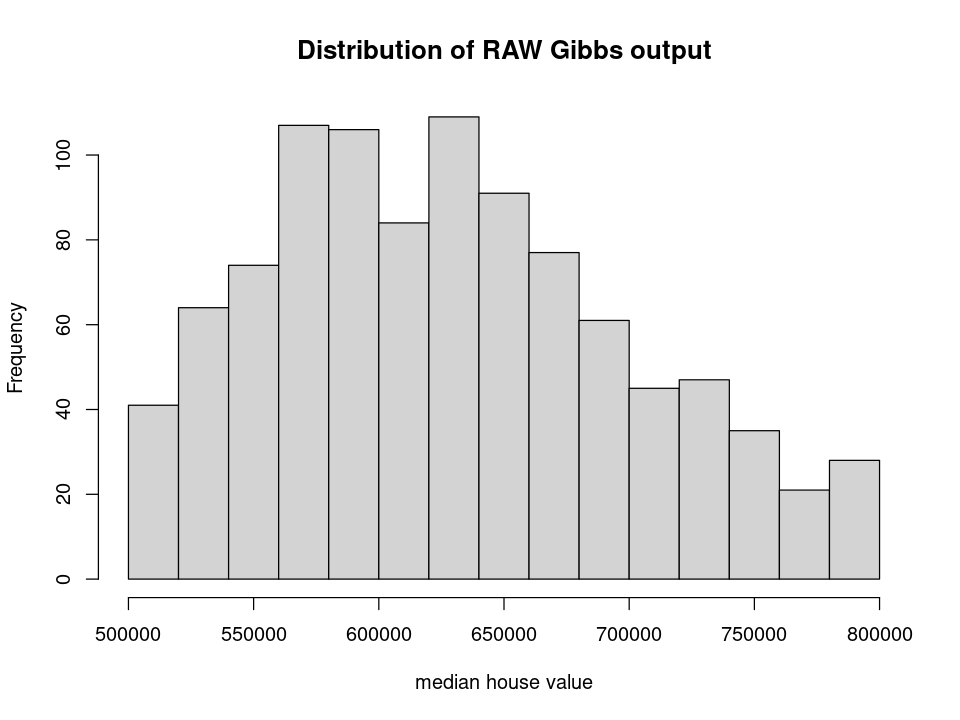

In [82]:
options(repr.plot.width= 8, repr.plot.height= 6)

hist(z_preds + 1, breaks=20, main="Distribution of RAW Gibbs output",
     xlab="median house value", cex.main=1.3)


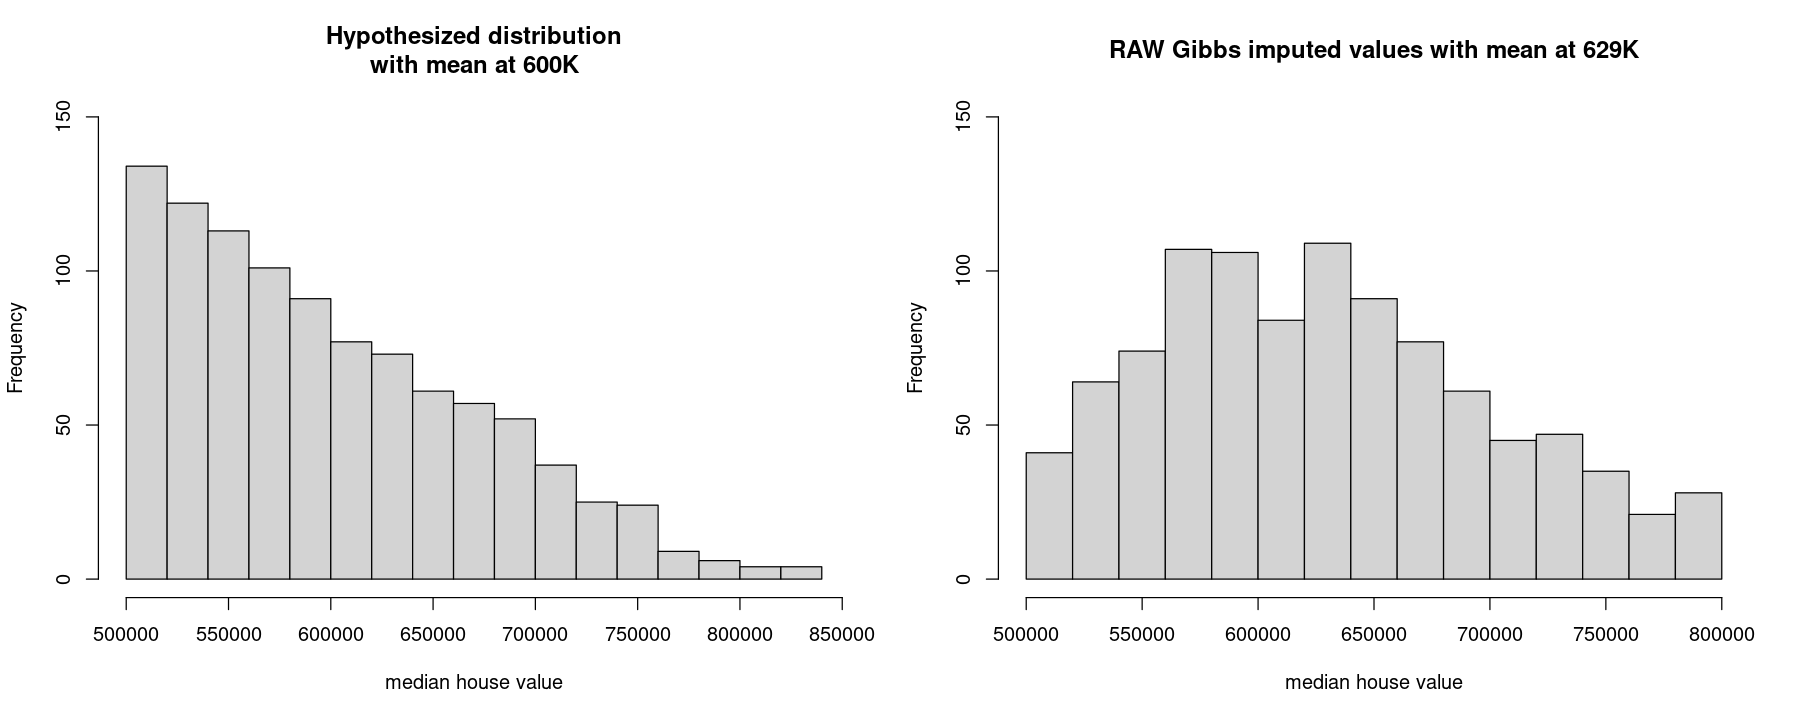

In [211]:
# Compare hypothesized distribution to the above distribution.

options(repr.plot.width= 15, repr.plot.height= 6)

mat <- t(as.matrix(c(1,2)))
layout(mat, widths = rep.int(20, ncol(mat)),
       heights = rep.int(7, nrow(mat)), respect = FALSE)

# Left panel.
hist(imputed_vals_tmp, breaks=20, main="Hypothesized distribution
with mean at 600K", ylim=c(0, 150), xlab="median house value")

# Right panel.
hist(z_preds, breaks=20, main="RAW Gibbs imputed values with mean at 629K",
     ylim=c(0, 150), xlab="median house value")


In [92]:
# Recall that the mean of our hypothesized distribution
# is still at 600K.

summary(imputed_vals_tmp)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 500000  539000  587000  600037  649000  822000 

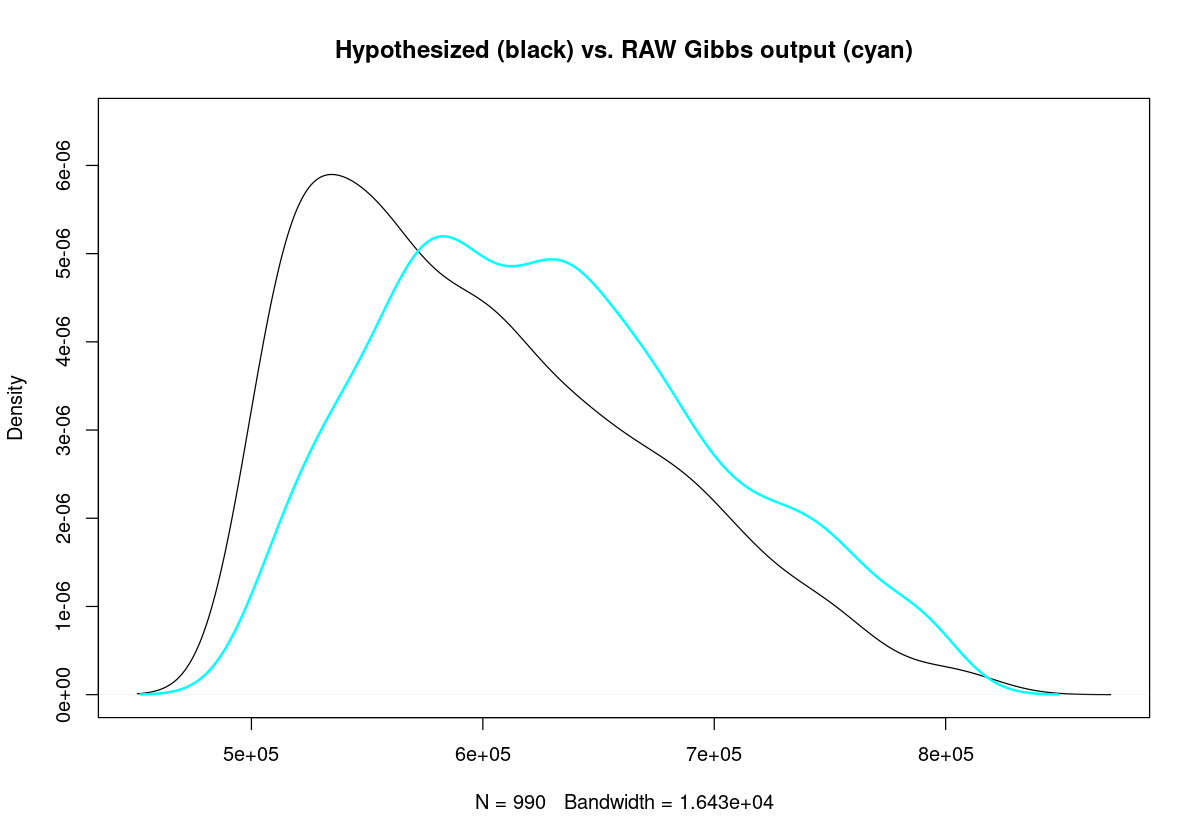

In [85]:
# Compare the density curves.

options(repr.plot.width= 10, repr.plot.height= 7)

fit <- density(imputed_vals_tmp)
plot(fit, ylim=c(0, 6.5e-06), main="Hypothesized (black) vs. RAW Gibbs output (cyan)")

lines(density(z_preds), col= "cyan", lwd=2)


In [89]:
# Adjust the Gibbs output so that the mean is closer to 
# 604K.

(z_means_bar <- mean(z_means))

z_means_adj <- z_means + (589000^response_var_power - z_means_bar)
summary(z_means_adj)
round(mean(z_means_adj)^inv_pwr)


[1] 11.031

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   10.8    10.9    10.9    10.9    11.0    11.3 

[1] 589000

In [90]:
C_upper


[1] 11.549

In [91]:
# Get some new, adjusted predictions.

# Also adjust C_upper a bit.

C_upper_adj <- 11.46

set.seed(1931)
preds_adj02 <- round(rnorm.trunc03(n.censored, z_means_adj, z_sds, lo=C, hi=C_upper_adj), 5)
preds_adj02 <- round(preds_adj02^inv_pwr)
summary(preds_adj02)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 500423  553773  597836  605056  647931  766141 

In [ ]:
### COMMENT:

# The mean is now around where we expect it to be.


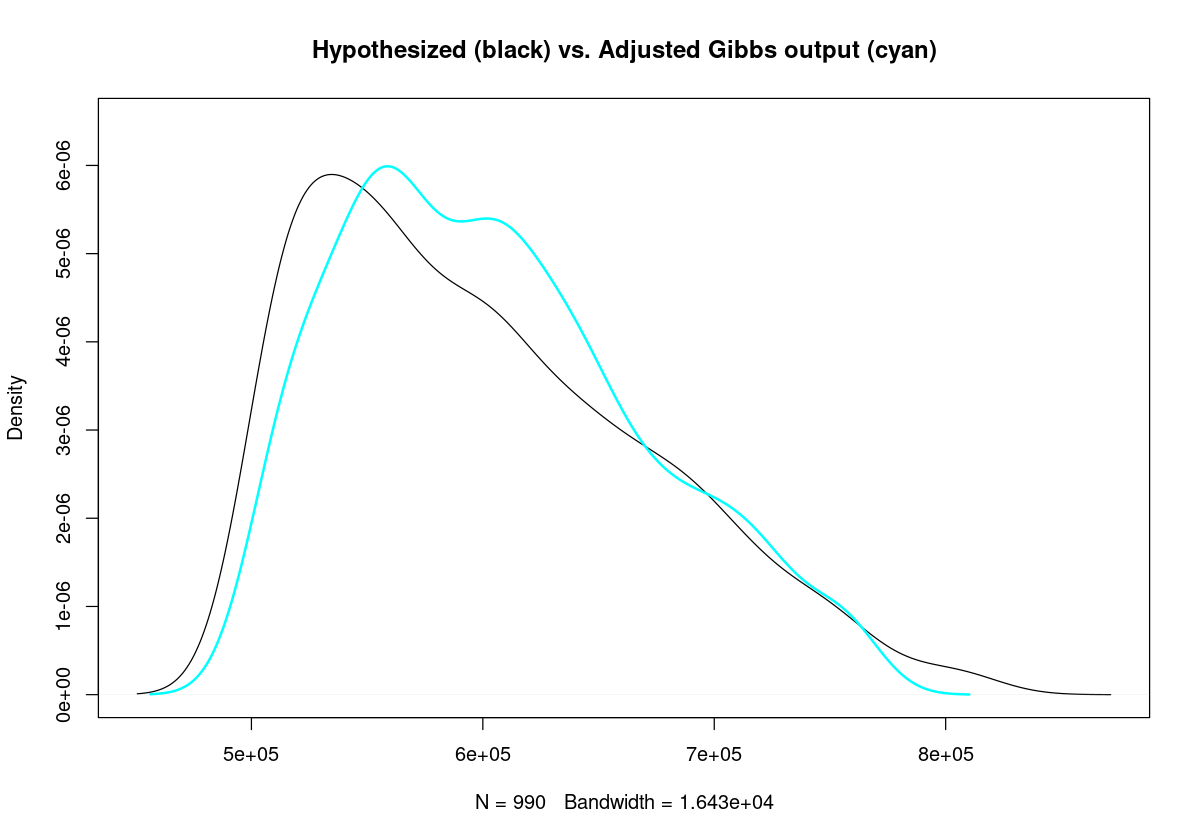

In [93]:
# Compare the adjusted values to the hypothesized distribution.

options(repr.plot.width= 10, repr.plot.height= 7)

fit <- density(imputed_vals_tmp)
plot(fit, ylim=c(0, 6.5e-06), main="Hypothesized (black) vs. Adjusted Gibbs output (cyan)")

lines(density(preds_adj02), col= "cyan", lwd=2)


In [ ]:
### COMMENT:

# The shape of the adjusted Gibbs output is fairly close
# to what we hypothesize.  Although one would expect 
# more values to be found between 500K and 550K, the 
# difference is less than what the above plot suggests
# because I am assuming a mean of 604K for the hypothesized
# distribution rather than 600K.  If I were to re-do the
# hypothesized distribution to bring the mean closer to 
# 604K, the black curve in the above plot would shift over
# to the right, more-so than one might think.

# The Approach 1 adjustment we have made, though, is not
# that disruptive to the original Gibbs output.  And, because
# we have brought the mean closer to the predicted mean, and
# there is reason to believe the predicted mean is closer to
# where the actual mean lies, the RSS score (if we could 
# measure it) should be better after the adjustment.  See
# Appendix C for more on RSS scores.


In [94]:
# Assign imputed values.

newdat_adj01 <- dat
newdat_adj01$median_house_value[censored] <- preds_adj02
summary(newdat_adj01$median_house_value)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  15000  119600  179800  211956  264950  766141 

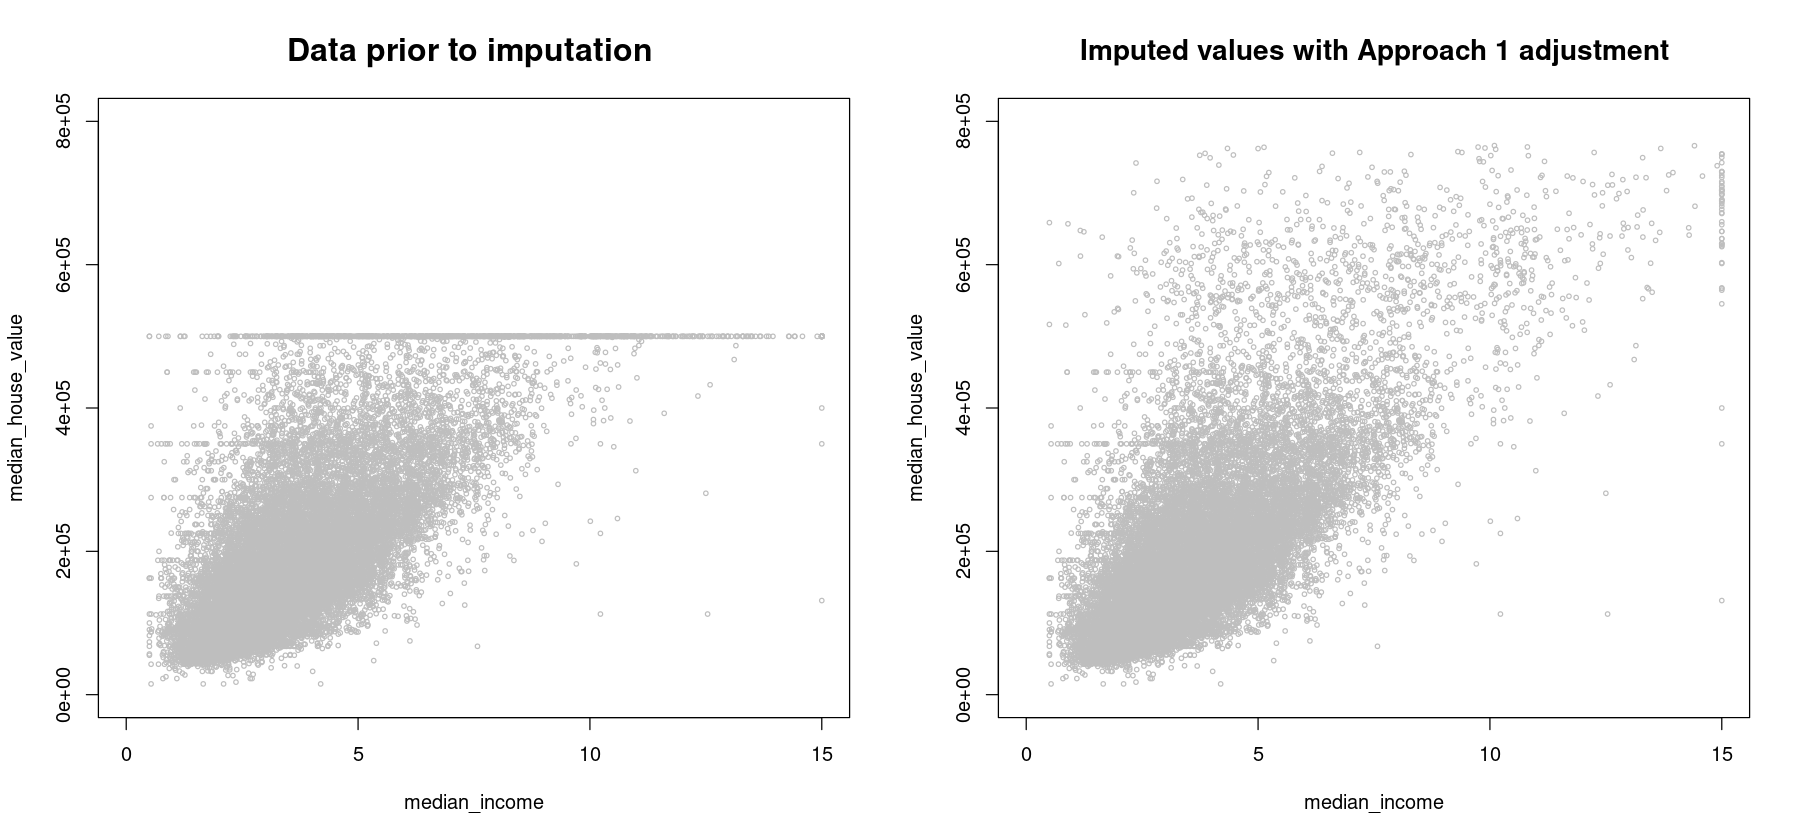

In [95]:
# Plot both before and after.

options(repr.plot.width= 15, repr.plot.height= 7)

mat <- t(as.matrix(c(1,2)))
layout(mat, widths = rep.int(20, ncol(mat)),
       heights = rep.int(7, nrow(mat)), respect = FALSE)

# layout.show(n = 2)

# plot the "before" scatter
plot(dat$median_income, dat$median_house_value, type= "p", pch=1, cex=0.5, col="grey",
     xlab= "median_income", ylab= "median_house_value", ylim= c(0, 0.80e06), xlim= c(0, 15),
     main= "Data prior to imputation ", cex.main=1.6)


# plot the newly predicted values
plot(newdat_adj01$median_income, newdat_adj01$median_house_value, type= "p", pch=1, cex=0.5, col="grey",
     xlab= "median_income", ylab= "median_house_value", ylim= c(0, 0.80e06), xlim= c(0, 15),
     main= "Imputed values with Approach 1 adjustment", cex.main=1.4)


### Save to disk

In [96]:
# Save imputed values for median_house_value.

write.csv(newdat_adj01,
          file="/home/greg/Documents/stat/Geron_ML/datasets/housing/housing_cleaned_v03_adj01.csv",
          row.names=TRUE)


In [235]:
dat <- newdat
rm(newdat)


## Final Comments for Appendix B

The Gibbs sampler method of imputation does not necessarily give us an appropriate distribution shape for the imputed values, nor even an appropriate mean.  In appendices A and B I have shown how we can predict with some confidence where the mean of the imputed values ought to lie.  As we will see in Appendix C, adjusting the Gibbs output to re-situate the mean can be done without adversely affecting the quality of the predictions.

We can see from the final scatterplot above and the final overlay of density curves that we have a very good set of imputed values.  Here there was no need to use the Approach 2 method shown in appendices A and C.
